# Data Loading & Preview

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
df = pd.read_csv("data/cleaned/hate_speech_dataset.tsv")

print(df.head())


                                        cleaned_post          class  bi_class  \
0  jewish harvard professor noel ignatiev wants a...  implicit_hate         1   
1  higher education european culture imported con...       not_hate         0   
2           problem whites christians ahead free say       not_hate         0   
3  yasir qadhi hate preacher calling christians f...       not_hate         0   
4    million germans mass murdered destruction reich       not_hate         0   

   mul_class  
0          1  
1          0  
2          0  
3          0  
4          0  


In [4]:
print(df['bi_class'].value_counts())
print(df['mul_class'].value_counts())

bi_class
0    13270
1     8180
Name: count, dtype: int64
mul_class
0    13270
1     7094
2     1086
Name: count, dtype: int64


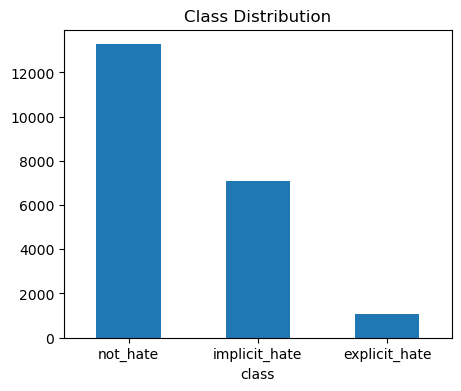

In [5]:
df["class"].value_counts().plot(
    kind="bar", title="Class Distribution", rot=0, figsize=(5,4)
)
plt.show()

The dataset exhibits a moderate class imbalance, with the non-hate class substantially larger than the hate class, which may cause the model to favor the majority class during training.

# Model Building

## Model 1: Binary

In [6]:
tfidf_vectorizer = TfidfVectorizer(
    use_idf=True,
    max_features=20000,
    ngram_range=(1, 2)
)

X = df["cleaned_post"]
y_binary = df["bi_class"]

# Train/Test split
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(
    X, y_binary,
    test_size=0.2,
    random_state=42,
    stratify=y_binary
)

# Fit TF-IDF on training only
X_train_bi_tfidf = tfidf_vectorizer.fit_transform(X_train_bi)
X_test_bi_tfidf = tfidf_vectorizer.transform(X_test_bi)

In [7]:
# Train NB
nb_bi = MultinomialNB()
nb_bi.fit(X_train_bi_tfidf, y_train_bi)

# Predict
y_pred_bi = nb_bi.predict(X_test_bi_tfidf)

print("Classification Report (Binary):")
print(classification_report(y_test_bi, y_pred_bi))

print("Confusion Matrix:")
print(confusion_matrix(y_test_bi, y_pred_bi))


Classification Report (Binary):
              precision    recall  f1-score   support

           0       0.71      0.92      0.80      2654
           1       0.74      0.38      0.50      1636

    accuracy                           0.71      4290
   macro avg       0.72      0.65      0.65      4290
weighted avg       0.72      0.71      0.68      4290

Confusion Matrix:
[[2438  216]
 [1018  618]]


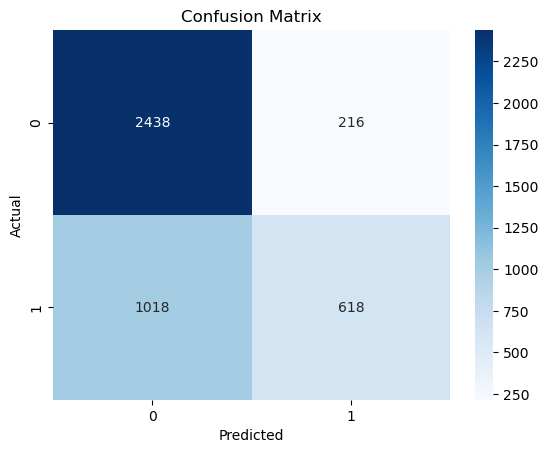

In [8]:
cm = confusion_matrix(y_test_bi, y_pred_bi, labels=nb_bi.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nb_bi.classes_, yticklabels=nb_bi.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

The binary model performs moderately well on the majority non-hate class, but due to the class imbalance in the dataset, it struggles to detect hate comments. The confusion matrix shows that a large number of hate instances (1018) are misclassified as non-hate, indicating low recall for the minority class.

## Model 2: Multi-class

In [9]:
y_multi = df["class"]

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X, y_multi,
    test_size=0.2,
    random_state=42,
    stratify=y_multi
)

# re-fit TF-IDF
tfidf_vectorizer_multi = TfidfVectorizer(
    use_idf=True,
    max_features=20000,
    ngram_range=(1, 2),
)

X_train_m_tfidf = tfidf_vectorizer_multi.fit_transform(X_train_m)
X_test_m_tfidf = tfidf_vectorizer_multi.transform(X_test_m)

# Train NB
nb_multi = MultinomialNB()
nb_multi.fit(X_train_m_tfidf, y_train_m)

# Predict
y_pred_m = nb_multi.predict(X_test_m_tfidf)

print("Classification Report (Multiclass):")
print(classification_report(y_test_m, y_pred_m))

print("Confusion Matrix:")
print(confusion_matrix(y_test_m, y_pred_m))

Classification Report (Multiclass):
               precision    recall  f1-score   support

explicit_hate       1.00      0.01      0.02       217
implicit_hate       0.64      0.26      0.37      1419
     not_hate       0.68      0.95      0.79      2654

     accuracy                           0.67      4290
    macro avg       0.77      0.40      0.39      4290
 weighted avg       0.68      0.67      0.61      4290

Confusion Matrix:
[[   2   64  151]
 [   0  365 1054]
 [   0  139 2515]]


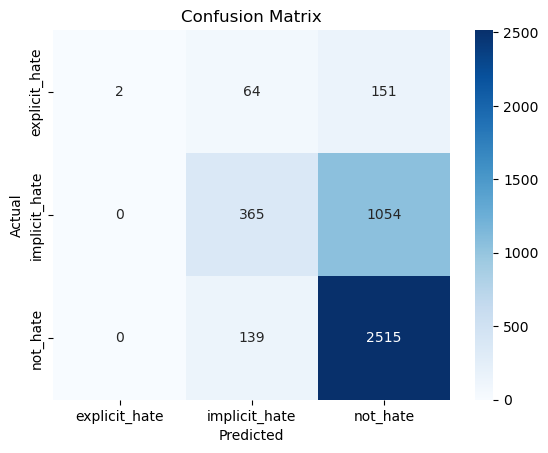

In [10]:
cm = confusion_matrix(y_test_m, y_pred_m, labels=nb_multi.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nb_multi.classes_, yticklabels=nb_multi.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

The multiclass model performs noticeably worse, largely due to the severe class imbalance. While it predicts the majority class (not_hate) well, it struggles heavily with both hate subclasses. Explicit hate is almost never detected (only 2 correct out of 217), and most implicit hate instances are misclassified as not_hate. The confusion matrix shows that minority classes are overwhelmingly absorbed into the majority label, indicating very poor recall for both explicit and implicit hate.